# Выбор локации для скважины

## Описание проекта

Нужно решить, где бурить новую скважину для добывающей компании «ТатШелГазНефть».

Для определения региона, в котором добыча нефти принесет максимальную прибыль, необходимо построить модель машинного обучения, используя пробы нефти из трех регионов, где были измерены качество нефти и объем ее запасов на 10 000 месторождениях в каждом регионе. Важно также провести анализ возможных рисков и прибыли, используя метод **Bootstrap**.

Как определяют локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков
- Строят модель и оценивают объём запасов
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины
- Прибыль равна суммарной прибыли отобранных месторождений

## Загрузка и подготовка данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant

In [5]:
# random_seed = randint(1, 9999999)
random_seed = 2299436 # some good seeds
print(random_seed)  # show seed

2299436


Создаем переменную `random_seed` для сохранения удачных random_state'ов

In [6]:
try:
    geo_0 = pd.read_csv('geo_data_0.csv')
    geo_1 = pd.read_csv('geo_data_1.csv')
    geo_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [7]:
def show_info(df):
    print(df.info())
    print(df.describe())

Создаем функция для вывода основной информации по региону, для первичного анализа.

In [8]:
show_info(geo_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.3437

Для первого региона (`geo_0`) выводим информацию для первичного ознакомления на экран и для проверки корректности парсинга данных. Также, выводим информацию о кол-ве пропусков и типах данных в таблице. Можем наблюдать, что пропуски отсутствуют. Типы данных соответствуют содержанию столбцов. Помимо этого, функция `show_info` выводит основные показатели для каждого столбца, кроме `id` скважен. По столбцам `f0`, `f1`, `f2` сложно что-то сказать, но `product` может дать поверхностное представление о добыче в регионе.

In [9]:
show_info(geo_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.7340

Для второго региона (`geo_1`) выводим такую же информацию. Можем наблюдать, что пропуски отсутствуют.  На основе двух регионов уже можно делать первичное сравнение по среднему, медиане и стандартному отклонению.

In [10]:
show_info(geo_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.8448

Для третьего региона (`geo_2`) выводим такую же информацию. Можем наблюдать, что пропуски отсутствуют. На основе трех выводов уже можно делать первичное сравнение по среднему, медиане и стандартному отклонению. Но для более детального сравнения нужно применять более комплексные инструменты. Пока что, можно только сказать, что добыча в регионах отличается и нужно это подробнее исследовать

In [11]:
for i, geo in enumerate([geo_0, geo_1, geo_2]):
    print('-'*5,)
    print(f'geo_{i}', '|')
    print('-'*5,)
    print(geo[geo.duplicated(subset=['id'], keep=False)].sort_values(by='id'))
    print('='*60)

-----
geo_0 |
-----
          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.54

После проверки на совпадающие id в разных регионах, были выявлены дубликаты. В сумме дубликатов не более 40. Поэтому, с ними можно ничего не делать. Они не смогут повлиять на результат.

In [12]:
geo_0 = geo_0.drop('id', axis=1)
geo_1 = geo_1.drop('id', axis=1)
geo_2 = geo_2.drop('id', axis=1)

Перед обучением модели, нужно избавиться от колонки id. ID - это искусственно сгенерированный набор символов, поэтому он не может как либо коррелировать с целевым признаком `product`

In [13]:
X = add_constant(geo_0)
pd.Series([VIF(X.values, i)
           for i in range(X.shape[1])],
          index=X.columns)

const      6.861281
f0         1.248703
f1         1.276589
f2         1.323671
product    1.380659
dtype: float64

Также, сделаем проверку данных на мультиколлинеарность. Мы не имеем представление о признаках (`f0`, `f1`, `f2`), поэтому нужно сделать максимально полное представление о них. Проверка показал, что признаки друг от друга не зависят и можно продолжать работать со всеми колонками.

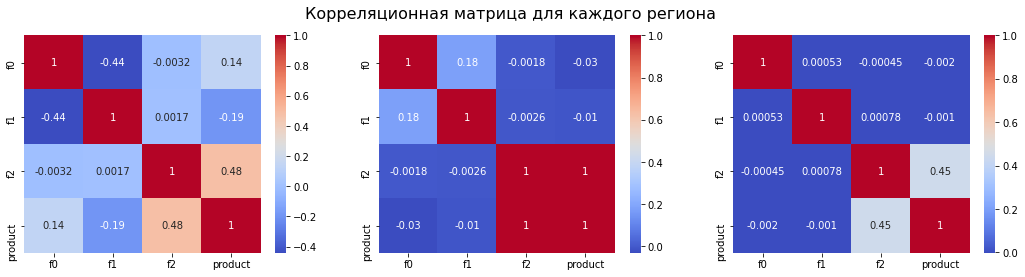

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.heatmap(geo_0.corr(), annot=True, ax=axes[0], cmap='coolwarm')
sns.heatmap(geo_1.corr(), annot=True, ax=axes[1], cmap='coolwarm')
sns.heatmap(geo_2.corr(), annot=True, ax=axes[2], cmap='coolwarm')

fig.suptitle("Корреляционная матрица для каждого региона", fontsize=16)

plt.show()

Матрица корреляции показывает интересную картину. Сильную корреляцию имеет только признак `f2`. Остальные корреляции стремятся к нулю. Так же, очень смущает второй датасет. Значение корреляции с признаком `f2` равно 1. Очень похоже на то, что датасет был сформирован синтетически. Поэтому, нужно посмотреть еще графики, если подтверждение будет усиливаться, стоит обратиться к команде сбора данных и прояснит и уточнить этот момент.
**Конечно, если бы это был реальный проект и кейс. Здесь очевидно, что данные сгенерированы командной Практикумама**

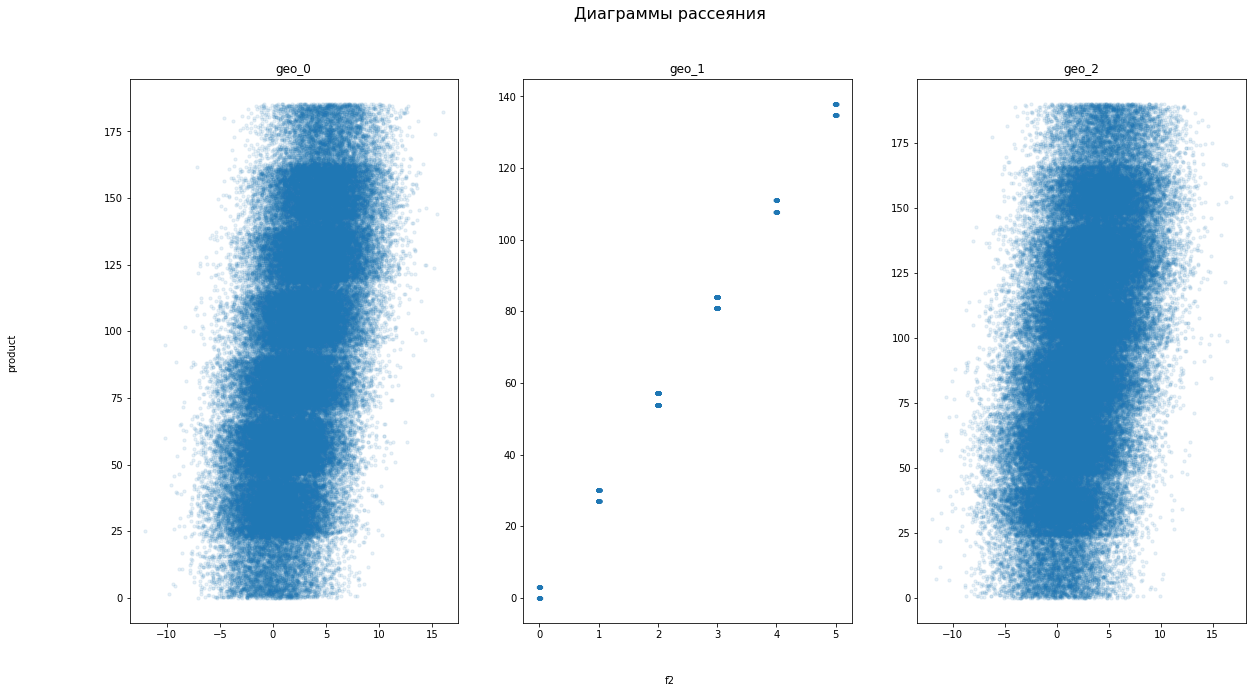

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].scatter(geo_0['f2'], geo_0['product'], s=10, alpha=0.1)
axes[0].set_title('geo_0')

axes[1].scatter(geo_1['f2'], geo_1['product'], s=10, alpha=0.1)
axes[1].set_title('geo_1')

axes[2].scatter(geo_2['f2'], geo_2['product'], s=10, alpha=0.1)
axes[2].set_title('geo_2')

fig.text(0.5, 0.04, 'f2', ha='center')
fig.text(0.04, 0.5, 'product', va='center', rotation='vertical')

fig.suptitle("Диаграммы рассеяния", fontsize=16)

plt.show()

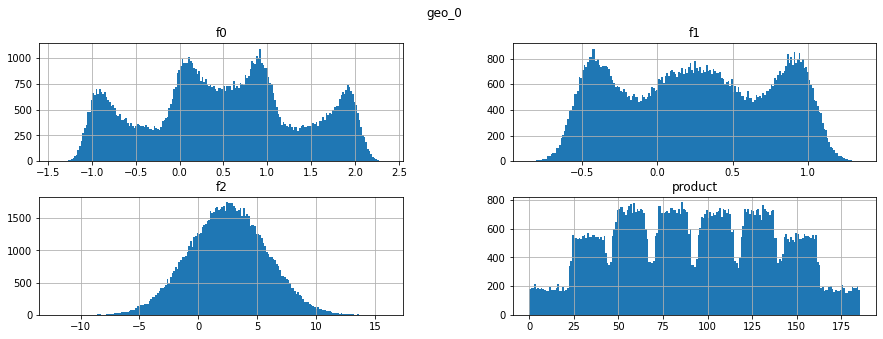

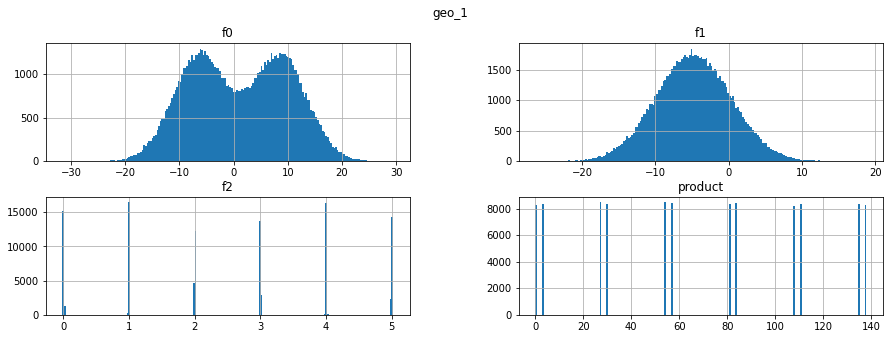

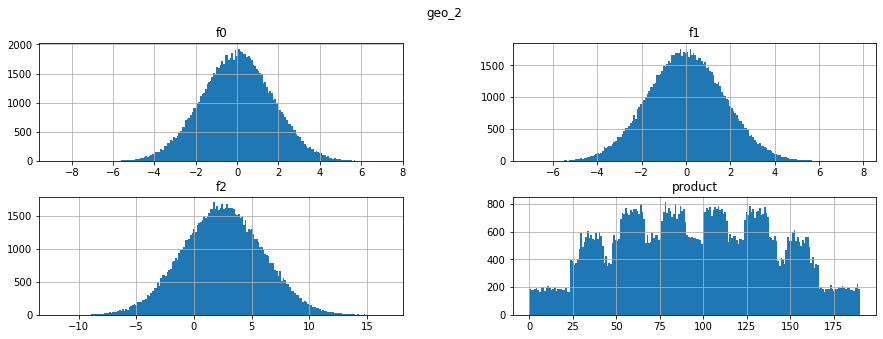

In [16]:
geo_0.hist(figsize=(15, 5), bins=200)
plt.suptitle('geo_0')
geo_1.hist(figsize=(15, 5), bins=200)
plt.suptitle('geo_1')
geo_2.hist(figsize=(15, 5), bins=200)
plt.suptitle('geo_2')
plt.show();

После ознакомления с дигаммой рассеяния и гистограммой. Можно однозначно сказать, что данные синтетические. Но мы конечно закрываем на это глаза и работаем дальше.

In [17]:
features_geo_0 = geo_0.drop('product', axis=1)
target_geo_0 = geo_0['product']

In [18]:
features_geo_1 = geo_1.drop('product', axis=1)
target_geo_1 = geo_1['product']

In [19]:
features_geo_2 = geo_2.drop('product', axis=1)
target_geo_2 = geo_2['product']

In [20]:
(
    features_geo_0.shape,
    target_geo_0.shape,
    features_geo_1.shape,
    target_geo_1.shape,
    features_geo_2.shape,
    target_geo_2.shape,
)

((100000, 3), (100000,), (100000, 3), (100000,), (100000, 3), (100000,))

Разделяем выборку на `features` и `target` признаки. После, вызываем метод shape, чтобы убедится в корректности разделения.

In [21]:
features_geo_0_train, features_geo_0_valid, target_geo_0_train, target_geo_0_valid = train_test_split(
    features_geo_0, target_geo_0, random_state=random_seed, train_size=0.75
)

In [22]:
features_geo_1_train, features_geo_1_valid, target_geo_1_train, target_geo_1_valid = train_test_split(
    features_geo_1, target_geo_1, random_state=random_seed, train_size=0.75
)

In [23]:
features_geo_2_train, features_geo_2_valid, target_geo_2_train, target_geo_2_valid = train_test_split(
    features_geo_2, target_geo_2, random_state=random_seed, train_size=0.75
)

In [24]:
(
    features_geo_0_train.shape,
    target_geo_0_train.shape,
    features_geo_0_valid.shape,
    target_geo_0_valid.shape,
    features_geo_1_train.shape,
    target_geo_1_train.shape,
    features_geo_1_valid.shape,
    target_geo_1_valid.shape,
    features_geo_2_train.shape,
    target_geo_2_train.shape,
    features_geo_2_valid.shape,
    target_geo_2_valid.shape,
)

((75000, 3),
 (75000,),
 (25000, 3),
 (25000,),
 (75000, 3),
 (75000,),
 (25000, 3),
 (25000,),
 (75000, 3),
 (75000,),
 (25000, 3),
 (25000,))

Разделяем выборки на `train` и `valid` подвыборки в соотношение 75% на 25%, соответственно. После, вызываем метод shape, чтобы убедится в корректности разделения.

In [25]:
def data_scaler(features_train, features_valid):
    numeric = [
        'f0',
        'f1',
        'f2'
    ]

    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

Создаем функцию для стандартизации признаков. Это поможет линейной регрессии правильно обучится и мы получим лучший результат.

In [26]:
features_train_list = [
    features_geo_0_train,
    features_geo_1_train,
    features_geo_2_train
]

features_valid_list = [
    features_geo_0_valid,
    features_geo_1_valid,
    features_geo_2_valid
]

for features_train, features_valid in zip(features_train_list, features_valid_list):
    data_scaler(features_train, features_valid)

Делаем стандартизацию для каждой подвыборки, с помощью функции `data_scaler`.

## Обучение и проверка модели

In [27]:
model_geo_0 = LinearRegression()
model_geo_0.fit(features_geo_0_train, target_geo_0_train)
prediction_geo_0 = model_geo_0.predict(features_geo_0_valid)

mse_geo_0 = MSE(target_geo_0_valid, prediction_geo_0)
rmse_geo_0 = MSE(mse_geo_0, squared=False)

print('geo_0')
print('mean product =', prediction_geo_0.mean())
print('rmse = ', rmse_geo_0)

geo_0
mean product = 92.38622008028804
rmse =  37.73441183933898


In [28]:
model_geo_1 = LinearRegression()
model_geo_1.fit(features_geo_1_train, target_geo_1_train)
prediction_geo_1 = model_geo_1.predict(features_geo_1_valid)

mse_geo_1 = MSE(target_geo_1_valid, prediction_geo_1)
rmse_geo_1 = MSE(mse_geo_1, squared=False)

print('geo_1')
print('mean product =', prediction_geo_1.mean())
print('rmse =', rmse_geo_1)

geo_1
mean product = 68.87916341073446
rmse = 0.8896431275137787


In [29]:
model_geo_2 = LinearRegression()
model_geo_2.fit(features_geo_2_train, target_geo_2_train)
prediction_geo_2 = model_geo_2.predict(features_geo_2_valid)

mse_geo_2 = MSE(target_geo_2_valid, prediction_geo_2)
rmse_geo_2 = MSE(mse_geo_2, squared=False)

print('geo_2')
print('mean product =', prediction_geo_2.mean())
print('rmse =', rmse_geo_2)

geo_2
mean product = 95.21935810967527
rmse = 40.15806576064485


Выше мы наблюдаем 3 вывода по трем регионам. Для каждого региона была выведена метрика `RMSE` и средние кол-во предсказанных запасов (`product`). Выводы можно сделать следующие:
- Предсказание для geo_0 имеет отклонение от действительности равное примерно 37.7 единицам. На основание предсказания, среднее запасов нефти в первом регионе 92.6 (тыс. баррелей) на одну скважину.
    Учитывая ошибку, кол-во запасов на одну скважину в среднем равно 74 - 111 (тыс. баррелей).
- Предсказание для geo_1 имеет отклонение от действительности равное примерно 0.9 единицам. На основание предсказания, среднее запасов нефти в первом регионе 68.8 (тыс. баррелей) на одну скважину.
    Ошибка получилась не значительной, ей можно пренебречь.
- Предсказание для geo_2 имеет отклонение от действительности равное примерно 40 единицам. На основание предсказания, среднее запасов нефти в первом регионе 95 (тыс. баррелей) на одну скважину.
    Учитывая ошибку, кол-во запасов на одну скважину в среднем равно 75 - 115 (тыс. баррелей).


In [30]:
gbm_geo_0 = GradientBoostingRegressor(random_state=random_seed)
gbm_geo_0.fit(features_geo_0_train, target_geo_0_train)
prediction_gbm_geo_0 = gbm_geo_0.predict(features_geo_0_valid)

mse_geo_0 = MSE(target_geo_0_valid, prediction_gbm_geo_0)
rmse_geo_0 = MSE(mse_geo_0, squared=False)

print('geo_0')
print('mean product =', prediction_gbm_geo_0.mean())
print('rmse = ', rmse_geo_0)

geo_0
mean product = 92.4429923672736
rmse =  37.25505462295905


In [31]:
gbm_geo_1 = GradientBoostingRegressor(random_state=random_seed)
gbm_geo_1.fit(features_geo_1_train, target_geo_1_train)
prediction_gbm_geo_1 = gbm_geo_1.predict(features_geo_1_valid)

mse_geo_1 = MSE(target_geo_1_valid, prediction_gbm_geo_1)
rmse_geo_1 = MSE(mse_geo_1, squared=False)

print('geo_1')
print('mean product =', prediction_gbm_geo_1.mean())
print('rmse =', rmse_geo_1)

geo_1
mean product = 68.88331092040407
rmse = 0.7139770312418232


In [32]:
gbm_geo_2 = GradientBoostingRegressor(random_state=random_seed)
gbm_geo_2.fit(features_geo_2_train, target_geo_2_train)
prediction_gbm_geo_2 = gbm_geo_2.predict(features_geo_2_valid)

mse_geo_2 = MSE(target_geo_2_valid, prediction_gbm_geo_2)
rmse_geo_2 = MSE(mse_geo_2, squared=False)

print('geo_2')
print('mean product =', prediction_gbm_geo_2.mean())
print('rmse =', rmse_geo_2)

geo_2
mean product = 95.35228007519804
rmse = 37.735022526209185


Также, обучим модель техникой градиентного бустинга. Можем наблюдать, что полученное среднее немного выше, а метрики значение метрики RMSE наоборот меньше. Это говорит о том, что данная модель будет более точно предсказывать кол-во запасов баррелей нефти. Будем ориентироваться на ее показатели, так же, и в выводе.

## Подготовка к расчёту прибыли

In [33]:
BUDGET = 10e9 # 10 млрд. рублей - бюджет

N_POINTS = 500 # выборка скважин
N_POINTS_FOR_DEVELOPMENT= 200 # кол-во лучших скважин

PRICE_PER_UNIT = 450_000 # Цена за 1 тыс. баррелей нефти

In [34]:
PROFIT_VALUE_RUB = BUDGET / N_POINTS_FOR_DEVELOPMENT
PROFIT_VALUE_BARREL = PROFIT_VALUE_RUB // PRICE_PER_UNIT

print('Порог безубыточности для скважины')
print(int(PROFIT_VALUE_RUB // 1e6), 'млн. рублей')
print(int(PROFIT_VALUE_BARREL), 'тыс. баррелей нефти')

Порог безубыточности для скважины
50 млн. рублей
111 тыс. баррелей нефти


Основываясь на этих данных сделаем расчет прибыли скважины, и риск понести убытки.

## Расчёт прибыли и рисков

In [35]:
def revenue(target, prediction, count):
    predict_df = pd.DataFrame({'prediction': prediction, 'target': target})
    predict_df_sorted = predict_df.sort_values(by='prediction', ascending=False)
    selected = predict_df_sorted['target'].head(count)
    return PRICE_PER_UNIT * selected.sum() - BUDGET

Создаем функцию для расчета прибыли

In [36]:
def bootstrap_profit(target, prediction):
    data = pd.DataFrame({'target': target, 'predicted': prediction})
    val = []
    for i in range(1000):
        sample = data.sample(n=N_POINTS, replace=True, random_state=i)
        profit = revenue(sample['target'], sample['predicted'], N_POINTS_FOR_DEVELOPMENT)
        val.append(profit)

    profits0 = pd.Series(val)
    mean_profit0 = profits0.mean()
    lower_profit0 = profits0.quantile(0.025)
    upper_profit0 = profits0.quantile(0.975)
    risk_of_losses0 = (profits0 < 0).mean()

    print('Средняя прибыль:', mean_profit0 // 1e6, '(млн. рублей)')
    print(f'95%-ый доверительный интервал: от {lower_profit0 // 1e6} (млн. рублей) до {upper_profit0 // 1e6} (млн. рублей)')
    print('Риск убытков:', round(risk_of_losses0 * 100, 1), '%')

Техникой `bootstrap` берем 1000 случайных выборок, состоящих из 500 значение (скважен). Выбираем из них 200 с наибольшей прибылью. На основе получившихся данных, выводим 95% доверительный интервал, среднее значение прибыли и риск убытка.

In [37]:
print('Первый регион')
print('-'*13)
bootstrap_profit(target_geo_0_valid, prediction_geo_0)
print('='*100)

print('Второй регион')
print('-'*13)
bootstrap_profit(target_geo_1_valid, prediction_geo_1)
print('='*100)

print('Третий регион')
print('-'*13)
bootstrap_profit(target_geo_2_valid, prediction_geo_2)
print('='*100)

Первый регион
-------------
Средняя прибыль: 443.0 (млн. рублей)
95%-ый доверительный интервал: от -69.0 (млн. рублей) до 944.0 (млн. рублей)
Риск убытков: 4.3 %
Второй регион
-------------
Средняя прибыль: 445.0 (млн. рублей)
95%-ый доверительный интервал: от 57.0 (млн. рублей) до 837.0 (млн. рублей)
Риск убытков: 1.1 %
Третий регион
-------------
Средняя прибыль: 431.0 (млн. рублей)
95%-ый доверительный интервал: от -106.0 (млн. рублей) до 982.0 (млн. рублей)
Риск убытков: 5.6 %


In [38]:
print('Первый регион')
print('-' * 13)
bootstrap_profit(target_geo_0_valid, prediction_gbm_geo_0)
print('=' * 100)

print('Второй регион')
print('-' * 13)
bootstrap_profit(target_geo_1_valid, prediction_gbm_geo_1)
print('=' * 100)

print('Третий регион')
print('-' * 13)
bootstrap_profit(target_geo_2_valid, prediction_gbm_geo_2)
print('=' * 100)

Первый регион
-------------
Средняя прибыль: 521.0 (млн. рублей)
95%-ый доверительный интервал: от 37.0 (млн. рублей) до 1013.0 (млн. рублей)
Риск убытков: 1.8 %
Второй регион
-------------
Средняя прибыль: 446.0 (млн. рублей)
95%-ый доверительный интервал: от 57.0 (млн. рублей) до 837.0 (млн. рублей)
Риск убытков: 1.1 %
Третий регион
-------------
Средняя прибыль: 737.0 (млн. рублей)
95%-ый доверительный интервал: от 213.0 (млн. рублей) до 1280.0 (млн. рублей)
Риск убытков: 0.4 %


## Вывод

### Сравнение моделей, на основе полученных данных из 3 регионов

Для каждого региона были получены требуемые значения 95% доверительный интервал, среднее значение прибыли, и риск понести убытки. Было обучено и протестировано две модели: линейная регрессия и градиентный бустинг.
На основание модели линейной регрессии можно сделать следующий вывод:
**Лучший регион для размещения новых скважен - второй (`geo_data_1`), на основание модели Линейной регрессии**
Обоснование:
- Второй регион, единственный, показал хороший уровень риска (ниже 2.5%). Риск понести убытки равен - 1.1%.
- У этого региона, самая высокая средняя прибыль - 445 (млн. рублей)
- Единственный показатель, по которому данный регион можно считать менее предпочтительным, это максимальная возможная прибыль в 95% доверительном интервале. В первом и третьем регионе этот показатель в пределах 950 (млн. рублей). Во втором он равен 837 (млн. рублей).
- Последний факт в пользу второго региона это безубыточный 95% доверительный интервал. Минимальная возможная прибыль равна 57 (млн. рублей). В остальных регионах в интервал входят отрицательный значения (убытки).

На основание модели градиентного бустинга можно сделать следующий вывод:

Максимальный шанс понести убытки равен 1.9% (в первом регионе). То есть, в любом регионе можно размещать скважины, при учете порогового значения 2.5%. Но среди всех регионов, один является наиболее предпочтительным.
**Лучший регион для размещения новых скважен - третий (`geo_data_2`), на основание модели Градиентного бустинга**

- Третий регион, единственный, показал уровень риска ниже 1%. Риск понести убытки равен - 0.4%.
- У этого региона, самая высокая возможная средняя прибыль - 737 (млн. рублей)
- Также, у данного региона наибольшая максимальная возможная прибыль в 95% доверительном интервале. В нем она равна 1 280 (млн. рублей). В первом и во втором регионе этот показатель в пределах 837 - 1 013 (млн. рублей).
- У третьего региона безубыточный 95% доверительный интервал. Минимальная возможная прибыль равна 213 (млн. рублей). В остальных регионах значения не превышают 57 млн. рублей.

### Вывод по моделям

В техническом задании было четко указанно использование линейной регрессии для анализа. Полученные результаты от нее можно использовать для предсказания и выбирать регионы, но более предпочтительным вариантом для анализа в данной ситуации является модель градиентного бустинга. Она показывает более высокую точность, с большим успехом находится зависимость в нелинейных данных. Линейная регрессия показала себя хорошо только на очень сомнительном дата сете, который нуждается в перепроверки. В остальных же регионах она показала уровень риска выше 2.5%. Это может говорить о том, что модель сможет корректно работать только с данным, в которых есть очень сильная линейная зависимость с высоким коэффициентом корреляции.
**Я рекомендую, сделать выбор в пользу модели Градиентного бустинга и использовать ее для анализа регионов для добычи.**

### Примечание по данным

В ходе исследования были обнаружены следующие моменты, на который стоит обратить внимание:

- Было обнаружено 36 дубликатов (повторяющиеся значения) в колонке `id` (всего 18 `id`). Данные дубликаты имеют отличные друг от друга показатели `f0` `f1` `f2` и `product`. Отличаются они сильно и отличия в колонке `product` могут быть более 100 тыс. баррелей.
- В данных из региона 2 (`geo_data_1`) было обнаружено не естественное распределение данных в колонках `f2` и `product`:
    + Колонки `f2` и `product` имеют коэффициент корреляции равный 1. То есть, кол-во нефти в скважине напрямую (на 100%) зависит от параметра `f2`. Стоит убедиться в корректности полученных измерений.
    + Распределение в колонке `product` похоже на столбчатую диаграмму с 12 выбросами. То есть, на все 10 000 скважен мы имеем только 12 уникальных значение. Как будто, кто-то округлил все полученные баррели до 12 определенных значений. По такому же принципу распределены значения в колонке `f2`. Вероятность получить такие данные в реальности стремится к нулю. **Стоит обеспокоиться этим вопросом и проверить при каких условиях и каким образом был проведен сбор данных для датасета `geo_data_1`.**